In [1]:
pip install -q ads

In [2]:
import ads
import pandas as pd

# ==============================
# 1. Configure NASA ADS API key
# ==============================
ads.config.token = ""  # <-- Insert ADS API token here

# ==============================
# 2. Define search queries
# ==============================
queries = [
    'abs:"radio frequency interference" AND abs:"machine learning" AND property:refereed AND collection:astronomy',
    'abs:"radio frequency interference" AND abs:"neural network" AND property:refereed AND collection:astronomy',
    'abs:"radio frequency interference" AND abs:"deep learning" AND property:refereed AND collection:astronomy',
    'abs:"RFI" AND abs:"machine learning" AND property:refereed AND collection:astronomy'
]

# ==============================
# 3. Collect data
# ==============================
all_data = []
seen_titles = set()

for query in queries:
    print(f"Processing query: {query[:70]}...")

    papers = list(
        ads.SearchQuery(
            q=query,
            fl=['title', 'author', 'year', 'doi', 'citation_count', 'pub', 'keyword'],
            max_pages=400
        )
    )

    for paper in papers:
        # Title
        title = paper.title[0] if paper.title else ""

        # Skip duplicates (case-insensitive)
        if title.lower() in seen_titles:
            continue
        seen_titles.add(title.lower())

        # Authors
        authors = ", ".join(paper.author) if paper.author else ""

        # Year
        year = int(paper.year) if paper.year else None

        # DOI link
        if paper.doi and len(paper.doi) > 0:
            doi_link = f"https://doi.org/{paper.doi[0]}"
        else:
            doi_link = ""

        # Citation count
        citation_count = paper.citation_count if paper.citation_count else 0

        # Journal
        journal = paper.pub if paper.pub else ""

        # Keywords
        keywords = ", ".join(paper.keyword) if paper.keyword else ""

        all_data.append({
            "Title": title,
            "Author(s)": authors,
            "Year": year,
            "DOI Link": doi_link,
            "Citation Count": citation_count,
            "Journal": journal,
            "Keywords": keywords
        })

# ==============================
# 4. Create DataFrame
# ==============================
df = pd.DataFrame(all_data)

# Remove duplicates again (extra safety)
df = df.drop_duplicates(subset=["Title"], keep="first")

# Sort by Year (desc) then Citation Count (desc)
df = df.sort_values(by=["Year", "Citation Count"], ascending=[False, False])

# ==============================
# 5. Export to Excel
# ==============================
output_filename = "nasa_ads_ML_combined_ALL.xlsx"
df.to_excel(output_filename, index=False)

print("\nTotal unique papers found:", len(df))
print(f"Data has been successfully saved to '{output_filename}'.")

Processing query: abs:"radio frequency interference" AND abs:"machine learning" AND prop...
Processing query: abs:"radio frequency interference" AND abs:"neural network" AND proper...
Processing query: abs:"radio frequency interference" AND abs:"deep learning" AND propert...
Processing query: abs:"RFI" AND abs:"machine learning" AND property:refereed AND collect...

Total unique papers found: 82
Data has been successfully saved to 'nasa_ads_ML_combined_ALL.xlsx'.


In [3]:
# Number of rows and columns
df.shape

# Quick info on columns and types
df.info()

# Summary stats for numeric columns (Year, Citation Count)
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 82 entries, 1 to 64
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           82 non-null     object
 1   Author(s)       82 non-null     object
 2   Year            82 non-null     int64 
 3   DOI Link        82 non-null     object
 4   Citation Count  82 non-null     int64 
 5   Journal         82 non-null     object
 6   Keywords        82 non-null     object
dtypes: int64(2), object(5)
memory usage: 5.1+ KB


,Year,Citation Count
count,82.000000,82.000000
mean,2022.170732,15.000000
std,3.102388,24.543235
min,2009.000000,0.000000
25%,2020.000000,1.000000
50%,2023.000000,5.000000
75%,2025.000000,18.000000
max,2026.000000,145.000000


In [4]:
# Papers per year
df['Year'].value_counts().sort_index(ascending=True)

,count
Year,
2009,1
2013,1
2016,1
2017,1
2018,5
2019,6
2020,8
2021,6
2022,10


In [5]:
# Top 10 journals by number of papers
df['Journal'].value_counts().head(10)

,count
Journal,
Monthly Notices of the Royal Astronomical Society,22
Astronomy and Computing,8
The Astronomical Journal,7
Astronomy and Astrophysics,6
Research in Astronomy and Astrophysics,6
Publications of the Astronomical Society of the Pacific,5
The Astrophysical Journal Supplement Series,4
Ph.D. Thesis,2
Publications of the Astronomical Society of Australia,2


In [6]:
# Basic citation stats
df['Citation Count'].describe()

# Most cited 10 papers
top_cited = df.sort_values('Citation Count', ascending=False).head(10)
top_cited[['Title', 'Year', 'Citation Count', 'Journal']]

,Title,Year,Citation Count,Journal
18,FETCH: A deep-learning based classifier for fa...,2020,145,Monthly Notices of the Royal Astronomical Society
37,Radio frequency interference mitigation using ...,2017,115,Astronomy and Computing
15,The High Time Resolution Universe survey - XIV...,2019,79,Monthly Notices of the Royal Astronomical Society
7,Separation of pulsar signals from noise using ...,2018,66,Astronomy and Computing
59,Optimizing sparse RFI prediction using deep le...,2019,50,Monthly Notices of the Royal Astronomical Society
24,First SETI Observations with China's Five-hund...,2020,41,The Astrophysical Journal
21,Deeper multi-redshift upper limits on the epoc...,2025,41,Astronomy and Astrophysics
9,A Machine Learning Classifier for Fast Radio B...,2016,41,Publications of the Astronomical Society of th...
25,Single-pulse classifier for the LOFAR Tied-Arr...,2018,40,Monthly Notices of the Royal Astronomical Society
46,Deep residual detection of radio frequency int...,2020,39,Monthly Notices of the Royal Astronomical Society


In [7]:
# How many papers contain each keyword (simple split on comma)
from collections import Counter

all_keywords = []

for kws in df['Keywords'].dropna():
    for k in kws.split(','):
        k = k.strip()
        if k:
            all_keywords.append(k)

keyword_counts = Counter(all_keywords)
keyword_counts.most_common(20)  # top 20 keywords

[('Astrophysics - Instrumentation and Methods for Astrophysics', 34),
 ('methods: data analysis', 24),
 ('Astrophysics - High Energy Astrophysical Phenomena', 13),
 ('pulsars: general', 11),
 ('Instrumentation and Methods for Astrophysics', 10),
 ('methods: statistical', 10),
 ('Radio astronomy', 8),
 ('techniques: interferometric', 8),
 ('techniques: image processing', 8),
 ('methods: observational', 7),
 ('1338', 6),
 ('Astronomy data analysis', 5),
 ('1858', 5),
 ('cosmology: observations', 5),
 ('Convolutional neural networks', 5),
 ('Search for extraterrestrial intelligence', 4),
 ('2127', 4),
 ('dark ages', 4),
 ('reionization', 4),
 ('first stars', 4)]

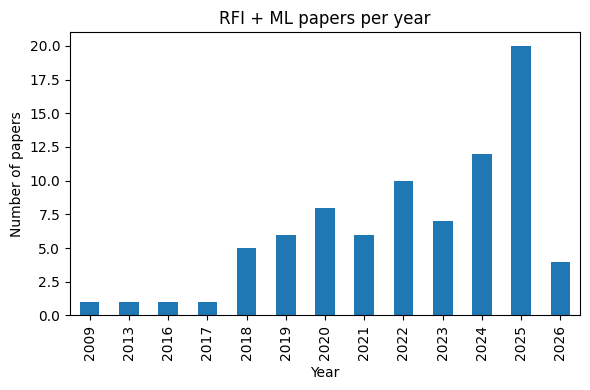

In [8]:
import matplotlib.pyplot as plt

# Bar plot: papers per year
year_counts = df['Year'].value_counts().sort_index()

plt.figure(figsize=(6,4))
year_counts.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Number of papers')
plt.title('RFI + ML papers per year')
plt.tight_layout()
plt.show()

/tmp/ipython-input-1066671999.py:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


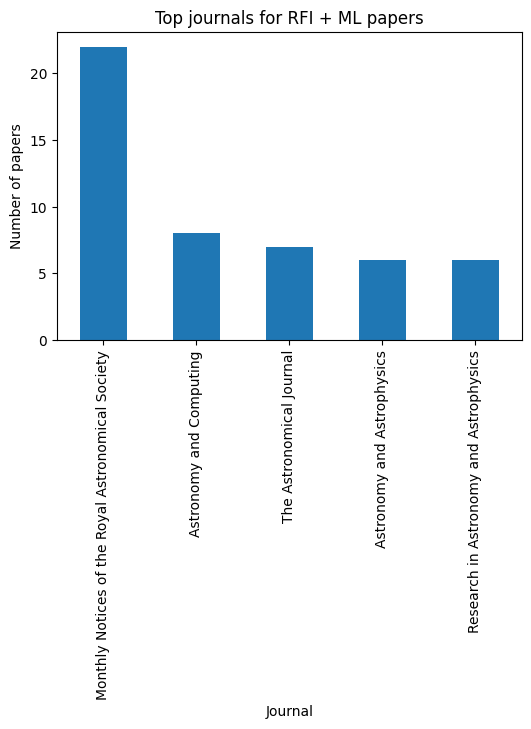

In [9]:
# Bar plot: top 5 journals
journal_counts = df['Journal'].value_counts().head(5)

plt.figure(figsize=(6,4))
journal_counts.plot(kind='bar')
plt.xlabel('Journal')
plt.ylabel('Number of papers')
plt.title('Top journals for RFI + ML papers')
plt.tight_layout()
plt.show()